# Analyze emails

### Read emails from DB

In [5]:
from pymongo import MongoClient

mongo_uri = "mongodb://localhost:27017/osint"

mongoConnection = MongoClient(mongo_uri)
db = mongoConnection.get_database()
emails_db = db["emails"]
emails = list(emails_db.find())

## Questions

- ¿Qué dominios son los que más correos envian?
- ¿Qué dominios son los que más tiempo llevan sin enviar un email?

### Analyze

__Prepare DF__

In [51]:
import pandas as pd
from datetime import datetime


def extract_domain(email):
        return email.split('@')[-1] if pd.notna(email) else None


def extract_month(date_str):
        if pd.isna(date_str):
                return None
        date_obj = pd.to_datetime(date_str, errors='coerce')
        return date_obj.strftime("%Y-%m") if pd.notna(date_obj) else None

def convert_month_to_number(month):
        if pd.isna(month):
                return None
        number = month.replace('-', '')
        return int(number)

df = pd.DataFrame(emails)

df['senderDomain'] = df['from'].apply(extract_domain)
df['month'] = df['date'].apply(extract_month)
df['numberMonth'] = df['month'].apply(convert_month_to_number)

unique_email_from_count = df['from'].nunique()
unique_domain_count = df['senderDomain'].nunique()
unique_emailId = df['emailId'].nunique()

print(f"Total: {unique_emailId}")
print(f"Deestinatarios: {unique_email_from_count}")
print(f"Dominios: {unique_domain_count}")


Total: 24827
Deestinatarios: 1663
Dominios: 783


__Analyze by sender__

In [31]:
grouped_from = df.groupby('from').size().reset_index(name='count').sort_values(by='count', ascending=False)

print("Top senders")
print(grouped_from.head(20))

Top senders
                                                 from  count
957                           HSN <news@hsnstore.com>   1223
1468                       Twitter <info@twitter.com>    637
835          Facebook <notification@facebookmail.com>    513
1149       Milanuncios <no-responder@milanuncios.com>    485
995                                          Internet    434
1119               Marta Garcia <hola@martagarcia.tv>    380
913   Google Alerts <googlealerts-noreply@google.com>    369
959                        HSN <soporte@hsnstore.com>    323
1536                    YouTube <noreply@youtube.com>    315
730           Dean Romero <contacto@blogger3cero.com>    300
75      "Booking.com" <email.campaign@sg.booking.com>    295
1434                   Todoist <no-reply@todoist.com>    270
1471                     Twitter <notify@twitter.com>    250
747                    Domestika <hola@domestika.org>    235
627                  Brian V <brianvmr2016@gmail.com>    225
1518        

__Analyze by domain__

In [39]:
grouped_domain = df.groupby('senderDomain').size().reset_index(name='count').sort_values(by='count', ascending=False)

print("Top domains")
print(grouped_domain.head(20))

Top domains
            senderDomain  count
366        hsnstore.com>   1781
728         twitter.com>    912
341          google.com>    653
298    facebookmail.com>    560
59            amazon.es>    512
514     milanuncios.com>    485
26              Internet    434
498      martagarcia.tv>    388
446        linkedin.com>    362
126          cambly.com>    337
338           gmail.com>    321
774         youtube.com>    320
108    blogger3cero.com>    301
658      sg.booking.com>    295
713         todoist.com>    295
220       domestika.org>    237
764          wonduu.com>    225
183    create.vista.com>    191
464  mail.instagram.com>    190
695        tapatalk.com>    185


__Analyze by date__

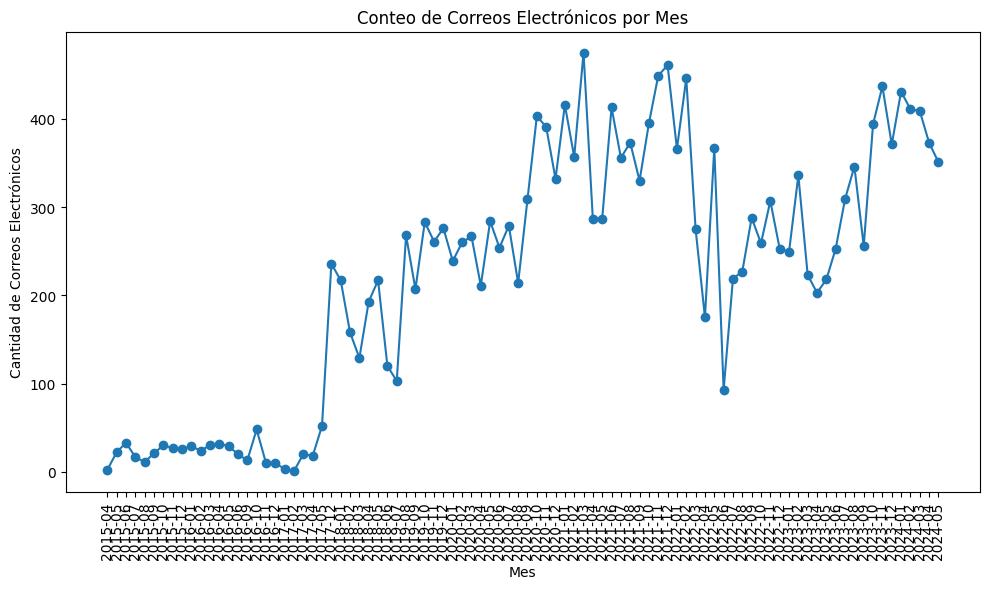

In [43]:
import matplotlib.pyplot as plt

grouped_months = df.groupby('month').size().reset_index(name='count').sort_values(by='count', ascending=False)
email_counts_by_month = df.groupby('month').size()

plt.figure(figsize=(10, 6))
plt.plot(email_counts_by_month.index, email_counts_by_month.values, marker='o', linestyle='-')
plt.title('Emails by month')
plt.xlabel('Mes')
plt.ylabel('Emails')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

__Analyze who is the max sender__

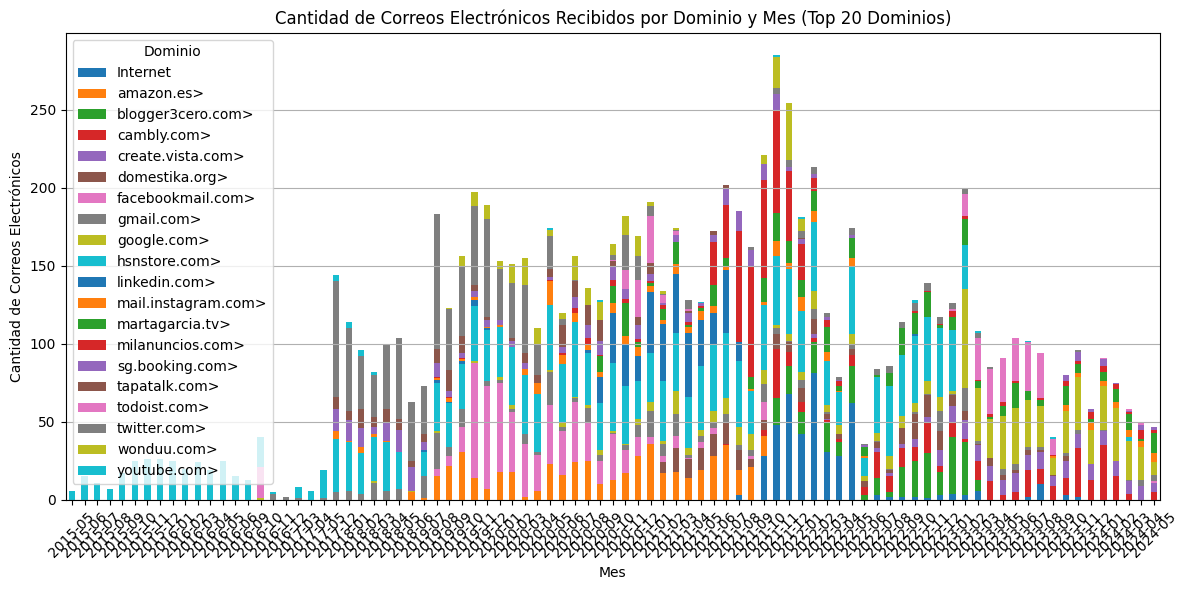

In [54]:
import matplotlib.pyplot as plt

domain_counts = df['senderDomain'].value_counts()
# Seleccionar los 20 dominios principales
top_20_domains = domain_counts.nlargest(20)

# Filtrar el DataFrame original para incluir solo los correos enviados por los 20 dominios principales
df_top_20_domains = df[df['senderDomain'].isin(top_20_domains.index)]

# Agrupar por 'month' y 'senderDomain' y contar la cantidad de correos en cada grupo
email_counts_by_domain = df_top_20_domains.groupby(['month', 'senderDomain']).size().unstack(fill_value=0)

email_counts_by_domain.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Cantidad de Correos Electrónicos Recibidos por Dominio y Mes (Top 20 Dominios)')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Correos Electrónicos')
plt.xticks(rotation=45)
plt.legend(title='Dominio')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


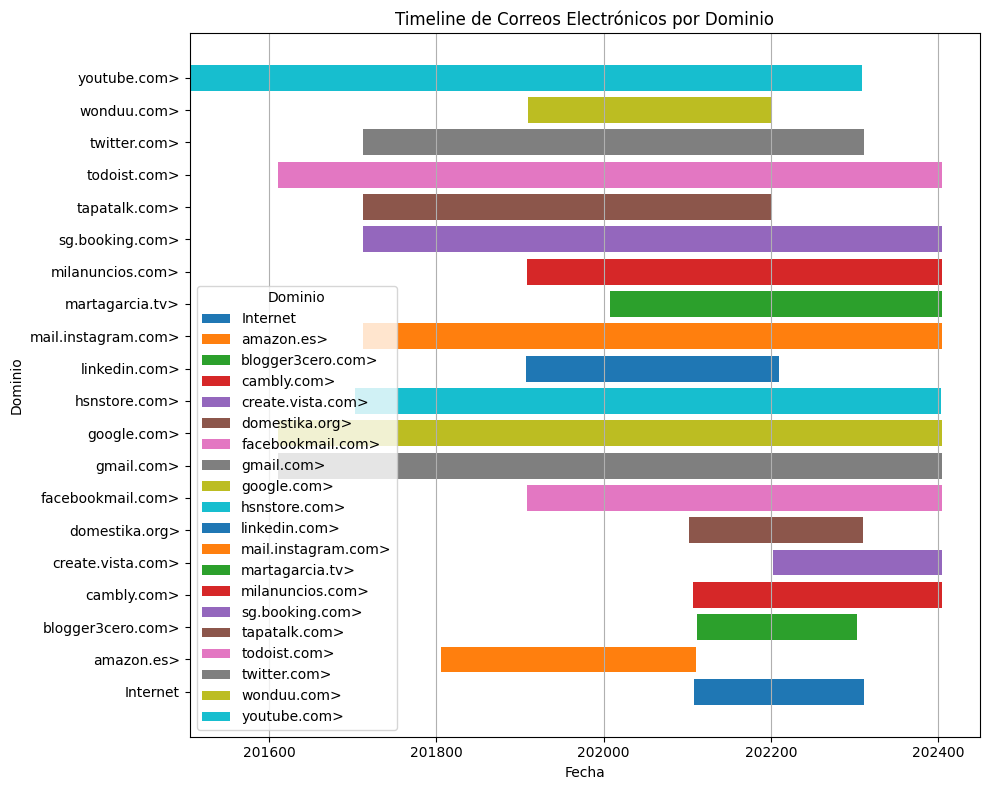

In [53]:
domain_counts = df['senderDomain'].value_counts()

# Seleccionar los 20 dominios principales
top_20_domains = domain_counts.nlargest(20)

# Filtrar el DataFrame original para incluir solo los correos enviados por los 20 dominios principales
df_top_20_domains = df[df['senderDomain'].isin(top_20_domains.index)]

# Obtener las fechas del primer y último correo electrónico para cada dominio
first_last_email_dates = df_top_20_domains.groupby('senderDomain')['numberMonth'].agg(['min', 'max'])

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 8))
for i, (domain, dates) in enumerate(first_last_email_dates.iterrows()):
    plt.barh(domain, width=dates['max'] - dates['min'], left=dates['min'], label=domain)

plt.title('Timeline de Correos Electrónicos por Dominio')
plt.xlabel('Fecha')
plt.ylabel('Dominio')
plt.legend(title='Dominio')
plt.grid(axis='x')
plt.tight_layout()
plt.show()